In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.graphics as smg
import json
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import math
import numpy as np
import warnings

## Load Data

### Migration influx

In [3]:
df_all = pd.read_csv(
    "../../data/processed/registrations/registrations_processed.csv", index_col=0, parse_dates=["date"]
)
df_all.set_index("date", inplace=True)
df_all["value"] = pd.to_numeric(df_all["value"], errors="coerce")
df_all["value"].fillna(1.0, inplace=True) # at least 1 person per timeframe for multiplicative seasonal decomposition

with open("../../data/config/country_names_registrations.json") as buf:
    countries = list(json.load(buf).keys())

series = {c: df_all[df_all.country==c].value for c in countries}
series["NL"]

date
2008-01-01     964.0
2008-02-01     883.0
2008-03-01     829.0
2008-04-01     956.0
2008-05-01     713.0
               ...  
2019-08-01    1076.0
2019-09-01    1130.0
2019-10-01     994.0
2019-11-01     815.0
2019-12-01     728.0
Name: value, Length: 144, dtype: float64

### Google trends

In [4]:
DATA_VERSION = "21-04-22"

LANGUAGE_ASSIGNMENT_FILE = "../../data/config/assignment_language_country.json"


def get_input_file(country: str) -> str:
    directory = f"../../data/processed/trends/{DATA_VERSION}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    return os.path.join(directory, f"processed_{country}.csv")


with open(LANGUAGE_ASSIGNMENT_FILE) as f:
    assignment_language_country = json.load(f)

dataframes = {
    c: pd.read_csv(get_input_file(c), header=[0, 1], index_col=0, parse_dates=[0])
    for c in countries
}

keyword_ids = dataframes[countries[0]].columns.get_level_values(1)

dataframes["NL"].head()


mean                                                         \
keyword_id          2         10         11         12         14         15   
date                                                                           
2007-01-01  12.142857   7.142857  20.714286   0.000000  19.428571  66.142857   
2007-02-01   0.000000   0.000000  56.857143   0.000000   0.000000  54.428571   
2007-03-01   0.000000  72.000000   0.000000  44.571429  13.142857  42.142857   
2007-04-01  16.571429  39.857143  22.285714   0.000000  12.285714  18.142857   
2007-05-01  11.428571   0.000000   5.857143   0.000000  18.285714   0.000000   

                                                        ...       sem  \
keyword_id         16         17         18         19  ...       114   
date                                                    ...             
2007-01-01   0.000000   0.000000  34.142857  28.142857  ...  0.746876   
2007-02-01  23.857143  36.000000   0.000000  32.000000  ...  0.918443   
2007-03-01   0.000000  36.428571   0.000000  37.285714  ...  1.445142   
2007-04-01   0.000000   0.000000   0.000000  35.285714  ...  1.148794   
2007-05-01   0.000000   0.000000  20.857143  37.857143  ...  1.078548   

                                                                        \
keyword_id       115       117       118       119       121       122   
date                                                                     
2007-01-01  4.838901  4.921838  1.269742  1.130890  1.242666  2.918391   
2007-02-01  2.542161  1.784285  2.307928  0.961858  1.360272  3.508008   
2007-03-01  5.588496  4.276180  1.737932  1.151751  0.911006  3.952094   
2007-04-01  4.495652  4.729413  1.442786  0.755929  1.127878  4.779491   
2007-05-01  6.014721  5.019011  1.397276  1.016865  0.404061  7.008256   

                                          
keyword_id       123       124       125  
date                                      
2007-01-01  1.056242  0.925820  0.480929  
2007-02-01  1.317078  1.192379  0.611678  
2007-03-01  0.972408  0.577350  0.606092  
2007-04-01  0.459221  0.737711  0.714286  
2007-05-01  0.993174  0.968904  0.649437  

[5 rows x 96 columns]

## Analysis and plot functions

In [5]:
def plot_single_timeseries(ser, df, col, w_err_band=True, ax=None):
    ser.plot(ax=ax, label="lala")
    df.plot(y=("mean", col), ax=ax, secondary_y=True, legend=False)
    if w_err_band:
        if ax is None:
            ax = plt
        ax.fill_between(
            df.index,
            df["mean", col] - df["sem", col],
            df["mean", col] + df["sem", col],
            alpha=0.5,
        )


def plot_timeseries(k_id, dfs, ser, countries, n_cols=3, title=None, w_err_band=False):
    n_rows = math.ceil(len(countries) / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
    fig.set_facecolor("white")

    for i in range(n_rows):
        for j in range(n_cols):
            try:
                country = countries[i * n_cols + j]
                ts = ser[country]
                df = dfs[country]
                ax = axs[i, j]
                plot_single_timeseries(ts, df, k_id, ax=ax, w_err_band=w_err_band)
                ts.plot(ax=ax)
                ax.set_title(country)
            except ValueError:
                pass

    if title is not None:
        title = fig.suptitle(title, fontsize=32)
    plt.tight_layout()

    return fig




### CCF

In [5]:
def plot_crosscorrelation(
    k_id,
    dfs_trends,
    ss_migration,
    countries,
    n_cols=3,
    n_lags=36,
    title=None,
    t_min="2010",
    t_max="2019",
):

    n_rows = math.ceil(len(countries) / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
    fig.set_facecolor("white")

    for i in range(n_rows):
        for j in range(n_cols):

            ax = axs[i, j]
            country = countries[i * n_cols + j]

            y = dfs_trends[country]["mean", k_id]
            x = ss_migration[country]

            cross_corr = sm.tsa.ccf(x[t_min:t_max], y[t_min:t_max])

            n = len(x[t_min:t_max])
            ci_u, ci_l = -1 / n + 2 / np.sqrt(n), -1 / n - 2 / np.sqrt(n)

            ax.vlines(range(n_lags), 0, cross_corr[:n_lags])
            ax.axhline(0, c="black", lw=2)
            ax.axhline(ci_u, ls="--", c="black")
            ax.axhline(ci_l, ls="--", c="black")

            ax.set_title(country)

    if title is not None:
        fig.suptitle(title + " Keyword ID " + k_id, fontsize=32)
    plt.tight_layout()
    return fig



### Granger Causality

In [6]:
def test_granger(x_dep, x_ind, n_lags):
    try:
        x = pd.concat([x_dep, x_ind], axis=1)
        test_results = sm.tsa.stattools.grangercausalitytests(x, n_lags, verbose=False)
        f_values = [v[0]["ssr_ftest"][0] for v in test_results.values()]
        p_values = [v[0]["ssr_ftest"][1] for v in test_results.values()]
        return f_values, p_values
    except:
        # print(x_dep, x_ind)
        return np.zeros(n_lags), np.zeros(n_lags)


def plot_granger(
    k_id,
    dfs_trends,
    ss_migration,
    countries,
    n_cols=3,
    n_lags=24,
    title=None,
    t_min="2010",
    t_max="2019",
    what="f",
):

    n_rows = math.ceil(len(countries) / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
    fig.set_facecolor("white")

    for i in range(n_rows):
        for j in range(n_cols):

            ax = axs[i, j]
            country = countries[i * n_cols + j]

            y = dfs_trends[country]["mean", k_id]
            x = ss_migration[country]

            f_values, p_values = test_granger(x[t_min:t_max], y[t_min:t_max], n_lags)

            # ax.vlines(range(n_lags), 0, p_values[:n_lags])
            if what == "f":
                colors = [
                    "green" if p < 0.05 else "lightgrey" for p in p_values[:n_lags]
                ]
                ax.scatter(range(1, n_lags + 1), f_values[:n_lags], c=colors)
                ax.plot(range(1, n_lags + 1), f_values[:n_lags], ls="--", c="lightgrey")
            if what == "p":
                ax.plot(range(1, n_lags + 1), p_values[:n_lags], ls="--")
                ax.axhline(0.05, c="grey")
            # ax.scatter(
            #     range(n_lags),
            #     f_values[:n_lags],
            #     c=[0 if p < 0.05 else 1 for p in p_values[:n_lags]],
            # )
            # ax.axhline(0, c="black", lw=2)
            # ax.axhline(0.05, ls="--", c="black")

            ax.set_title(country)

    if title is not None:
        fig.suptitle(title, fontsize=32)
    plt.tight_layout()
    return fig


def get_best_granger_values(
    k_id, dfs_trends, ss_migration, countries, n_lags=24, t_min="2010", t_max="2019"
):

    opt_lags, min_p_values = [], []

    for country in countries:

        y = dfs_trends[country]["mean", k_id]
        x = ss_migration[country]

        f_values, p_values = test_granger(x[t_min:t_max], y[t_min:t_max], n_lags)

        min_p_values.append(np.min(p_values))
        opt_lags.append(np.argmin(p_values) + 1)

    return min_p_values, opt_lags


# get_best_granger_values(
#     "19", dataframes, series, countries,
# )


### Cointegration

In [7]:
def test_coint(x_dep, x_ind, **kwargs):
    x = pd.concat([x_dep, x_ind], axis=1)
    test_results = sm.tsa.stattools.coint(x_dep, x_ind, **kwargs)
    t_values = test_results[0]
    p_values = test_results[1]
    return t_values, p_values


def test_all_coint(
    k_id,
    dfs_trends,
    ss_migration,
    countries,
    t_min="2010",
    t_max="2019",
):

    t_values, p_values = [], []

    for country in countries:

        y = dfs_trends[country]["mean", k_id]
        x = ss_migration[country]

        t, p = test_coint(x[t_min:t_max], y[t_min:t_max])

        t_values.append(t)
        p_values.append(p)
    
    return pd.DataFrame({"country": countries, "t_coint": t_values, "p_coint": p_values})




## Analyze 'raw' data

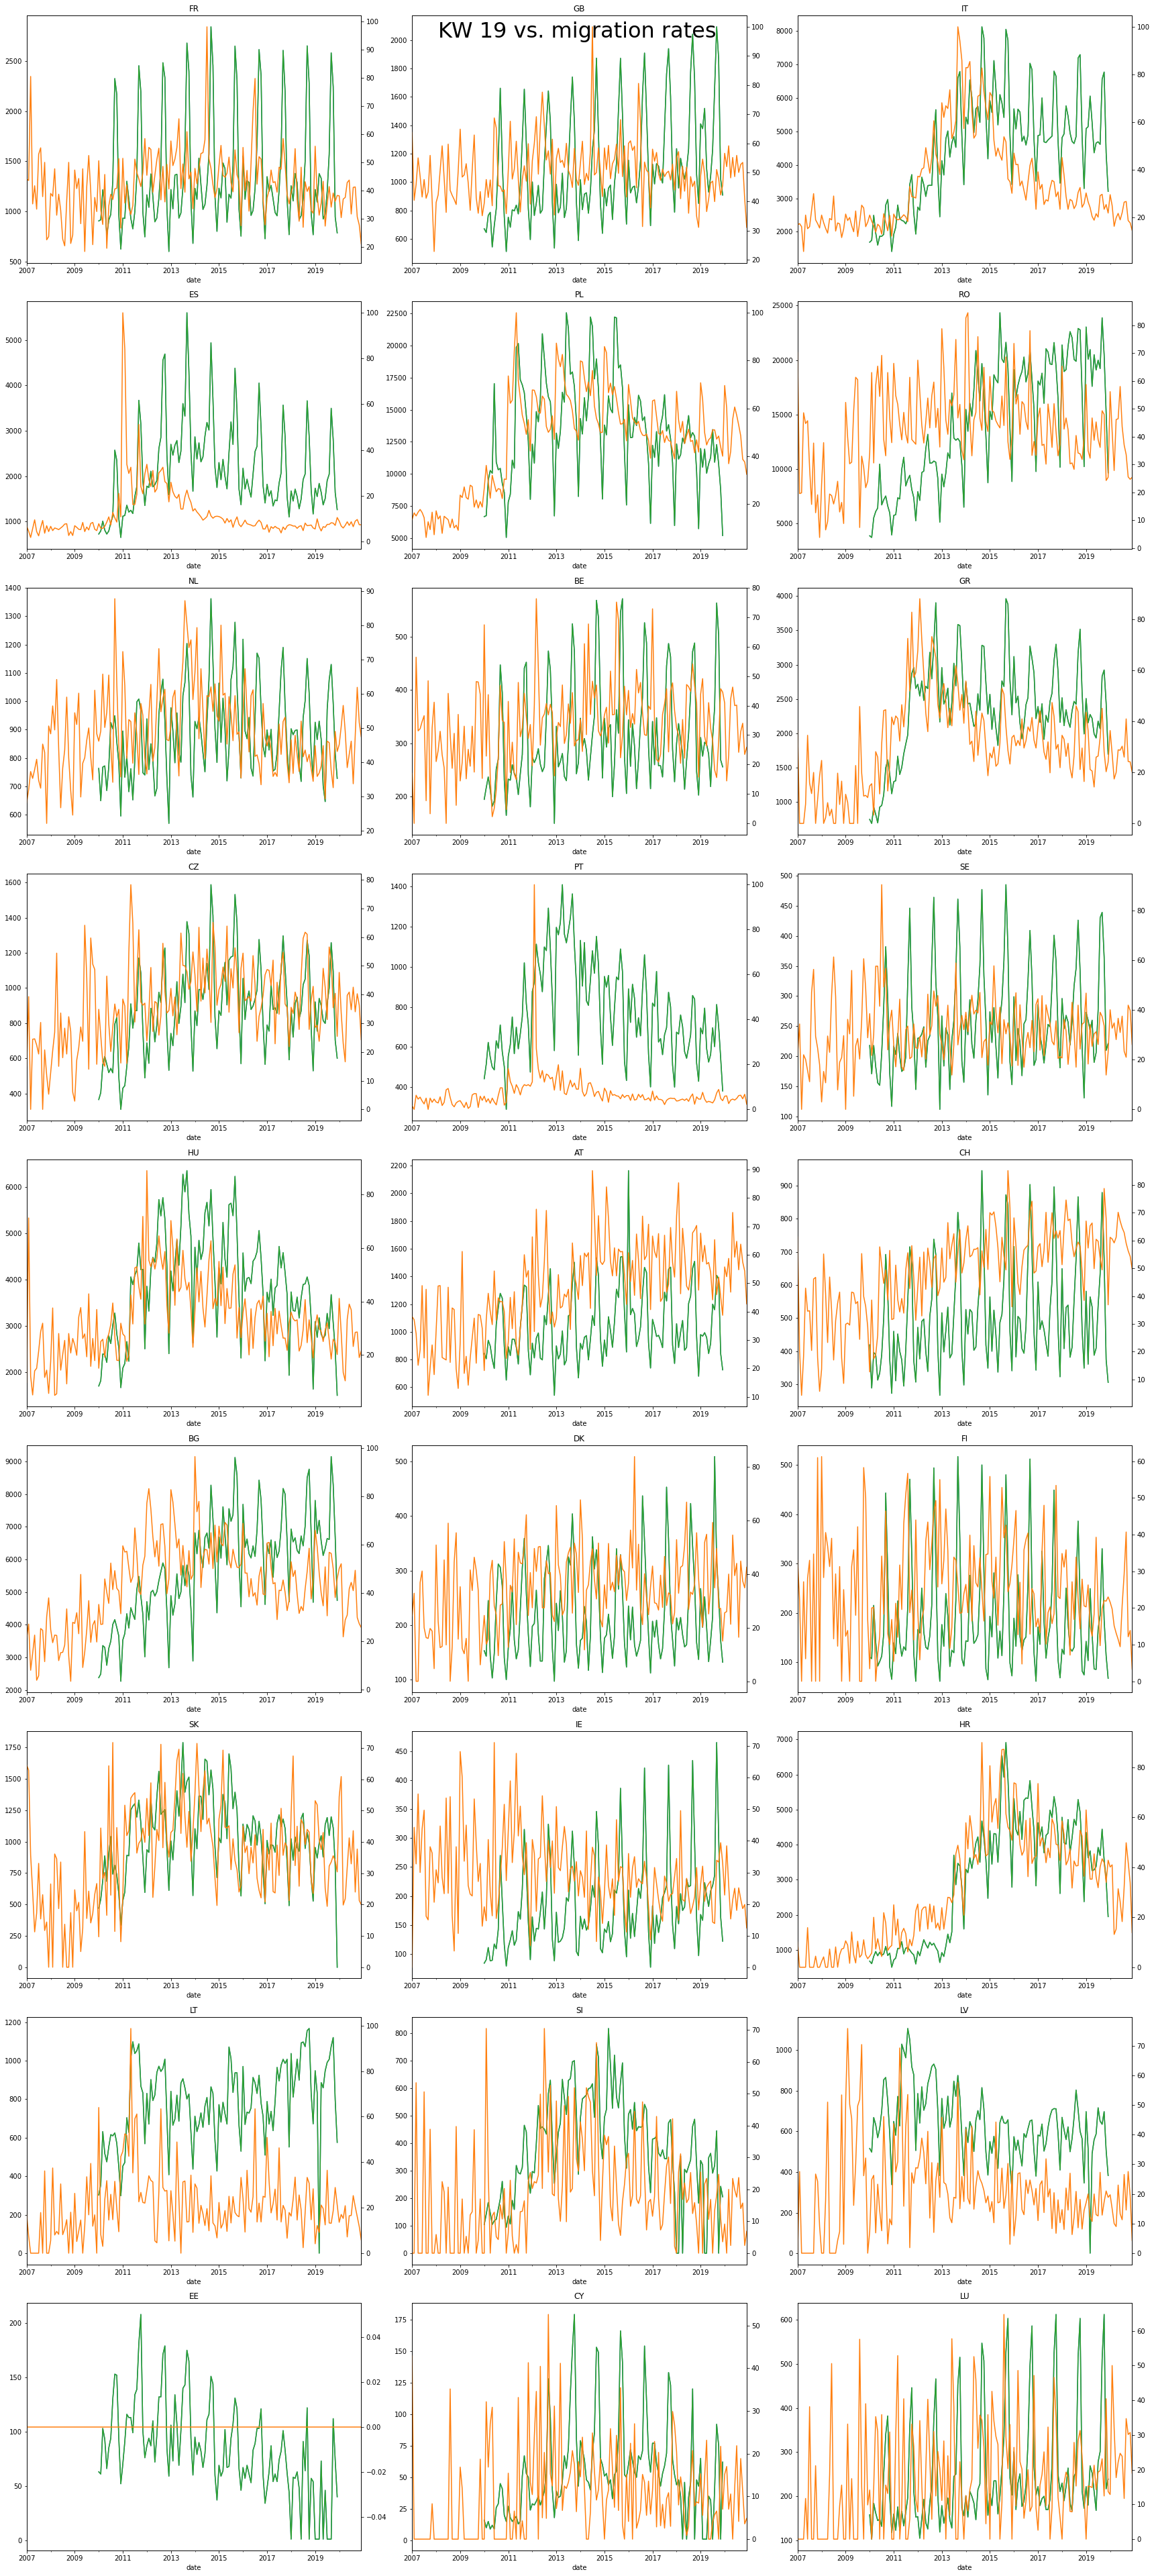

In [8]:

plot_timeseries(
    "19", dataframes, series, countries, title="KW 19 vs. migration rates"
)
plt.show()

/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1140: RuntimeWarning: invalid value encountered in true_divide
  return cvf / (np.std(x) * np.std(y))
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


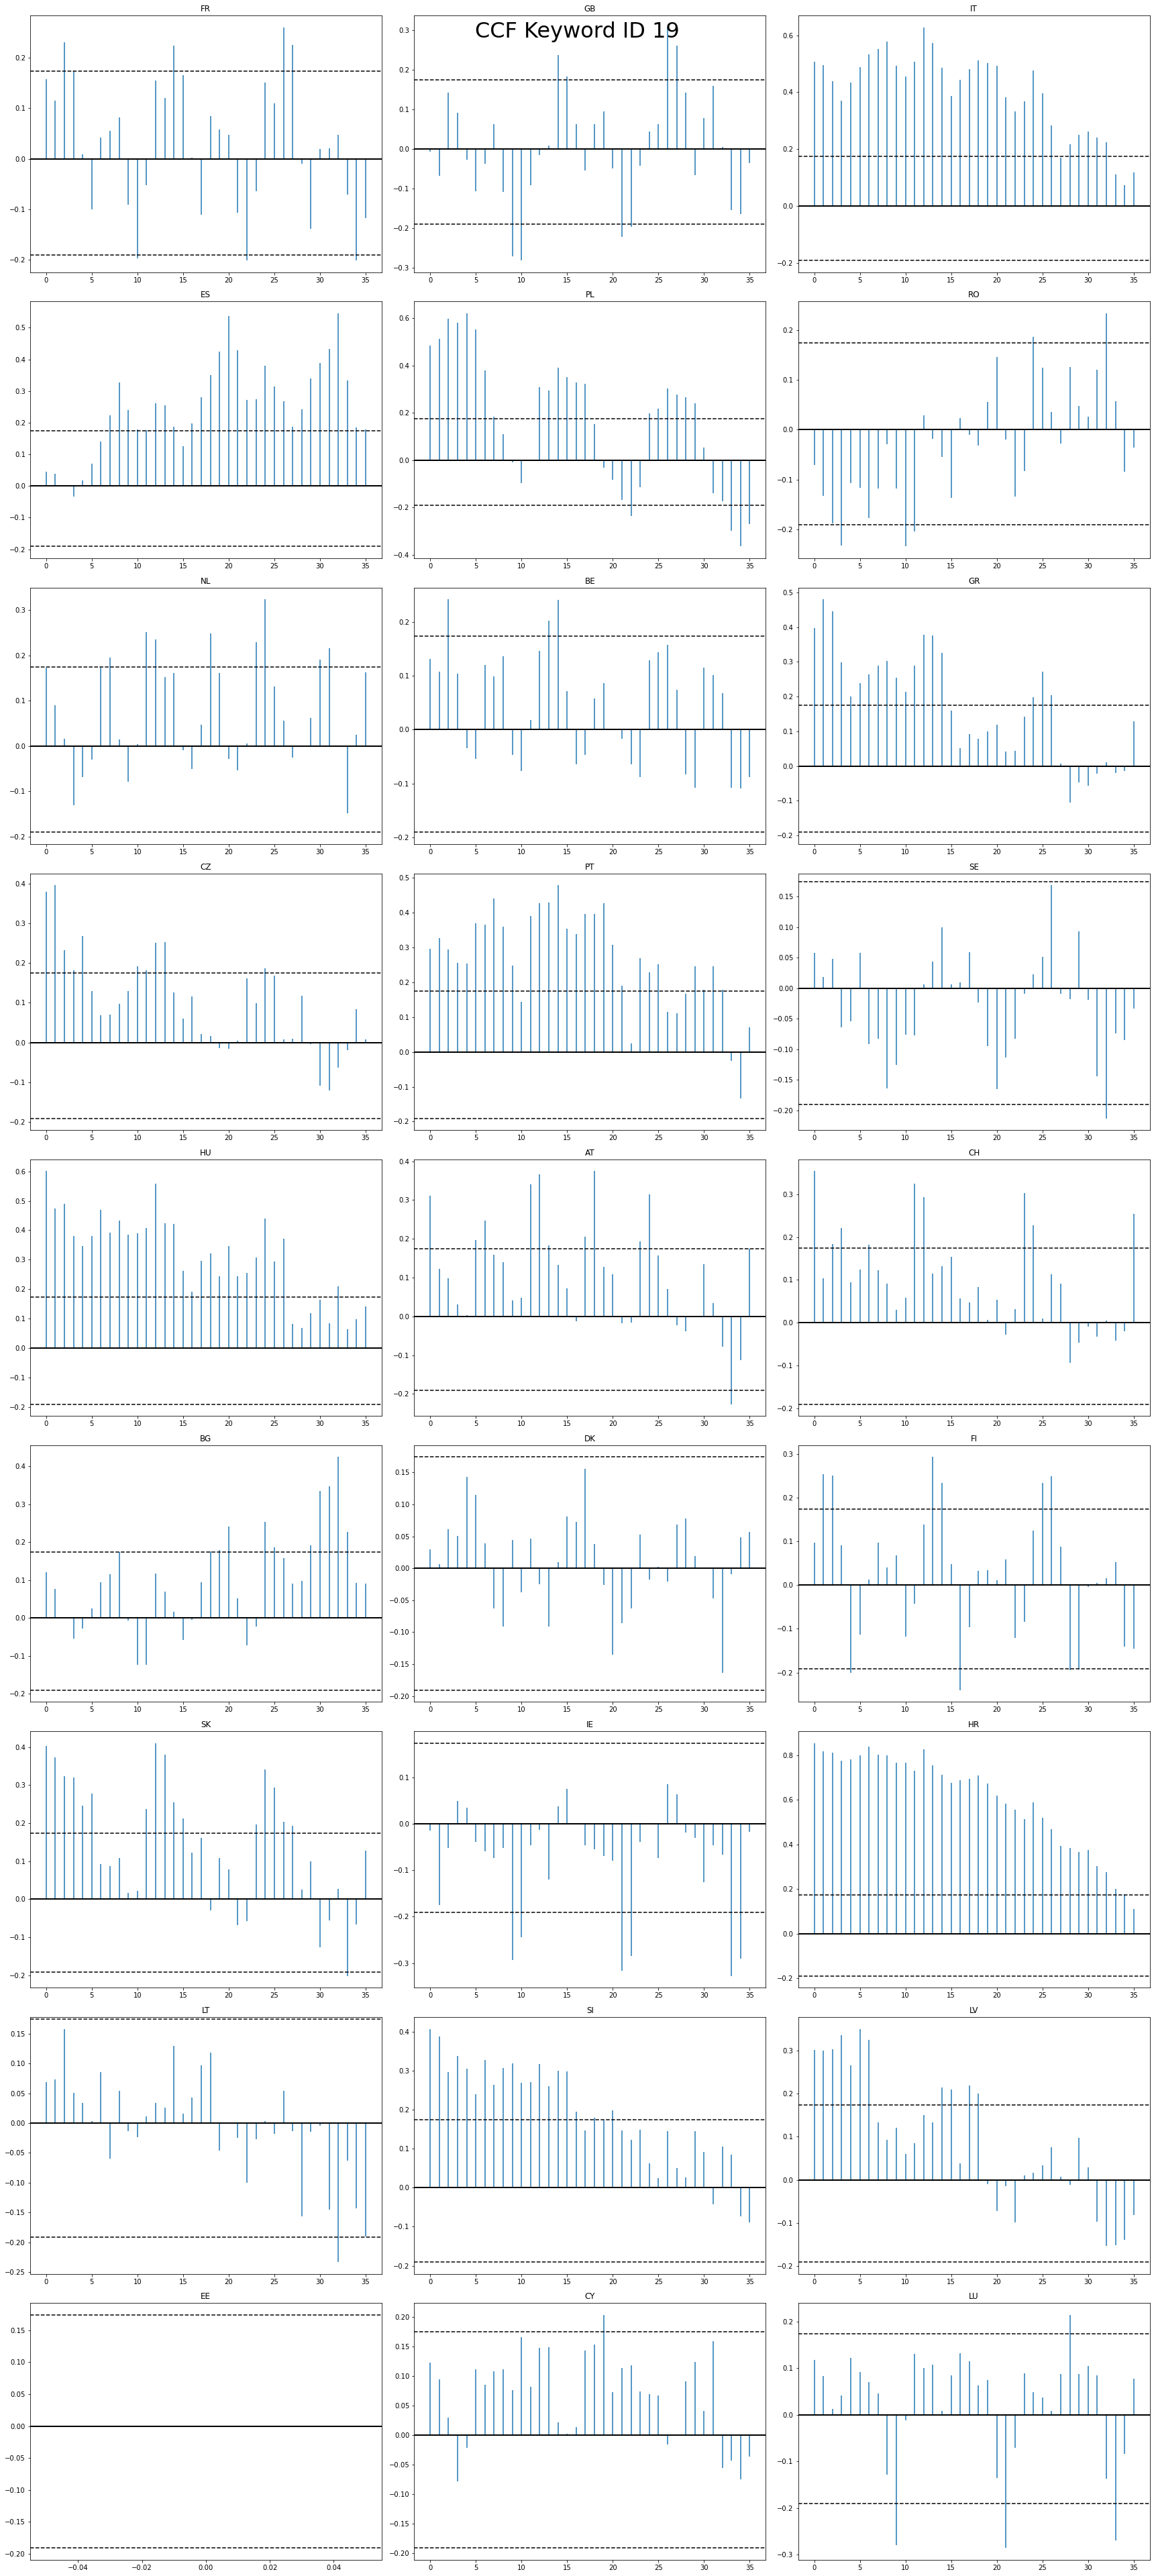

In [9]:
plot_crosscorrelation(
    "19",
    dataframes,
    series,
    countries,
    title="CCF",
)
plt.show()


In [10]:
test_all_coint("19", dataframes, series, countries)

country   t_coint   p_coint
0       FR -1.388137  0.801551
1       GB -0.497616  0.964501
2       IT -0.940934  0.913489
3       ES -2.254791  0.396315
4       PL -1.191117  0.860212
5       RO -1.283936  0.834530
6       NL -1.983157  0.537321
7       BE -2.064463  0.494949
8       GR -2.933854  0.126778
9       CZ -2.387423  0.330835
10      PT -1.760967  0.648481
11      SE -2.460416  0.296800
12      HU -1.573051  0.732129
13      AT -2.403122  0.323378
14      CH -2.092829  0.480116
15      BG -1.420561  0.790378
16      DK -2.270033  0.388597
17      FI -1.142830  0.872242
18      SK -2.131572  0.459879
19      IE -1.407558  0.794911
20      HR -1.134396  0.874253
21      LT -3.447599  0.037332
22      SI -1.611813  0.715878
23      LV -0.939635  0.913711
24      EE  0.832669  0.993900
25      CY -1.414747  0.792414
26      LU -0.782706  0.936939

## Rolling mean

In [11]:
# dfs_transformed = {c: dataframes[c].diff()[1:] for c in countries}
# dfs_transformed = {c: (dataframes[c] - dataframes[c].shift(12))[13:] for c in countries}
dfs_rm = {c: dataframes[c].rolling(12).mean()[12:] for c in countries}


In [12]:
# series_resampled = {c: series[c].resample("3M").mean() for c in countries}
series_rm = {c: series[c].rolling(12).mean()[12:] for c in countries}
# series_transformed = {c: (series[c].diff())[1:] for c in countries}
#series_transformed = series


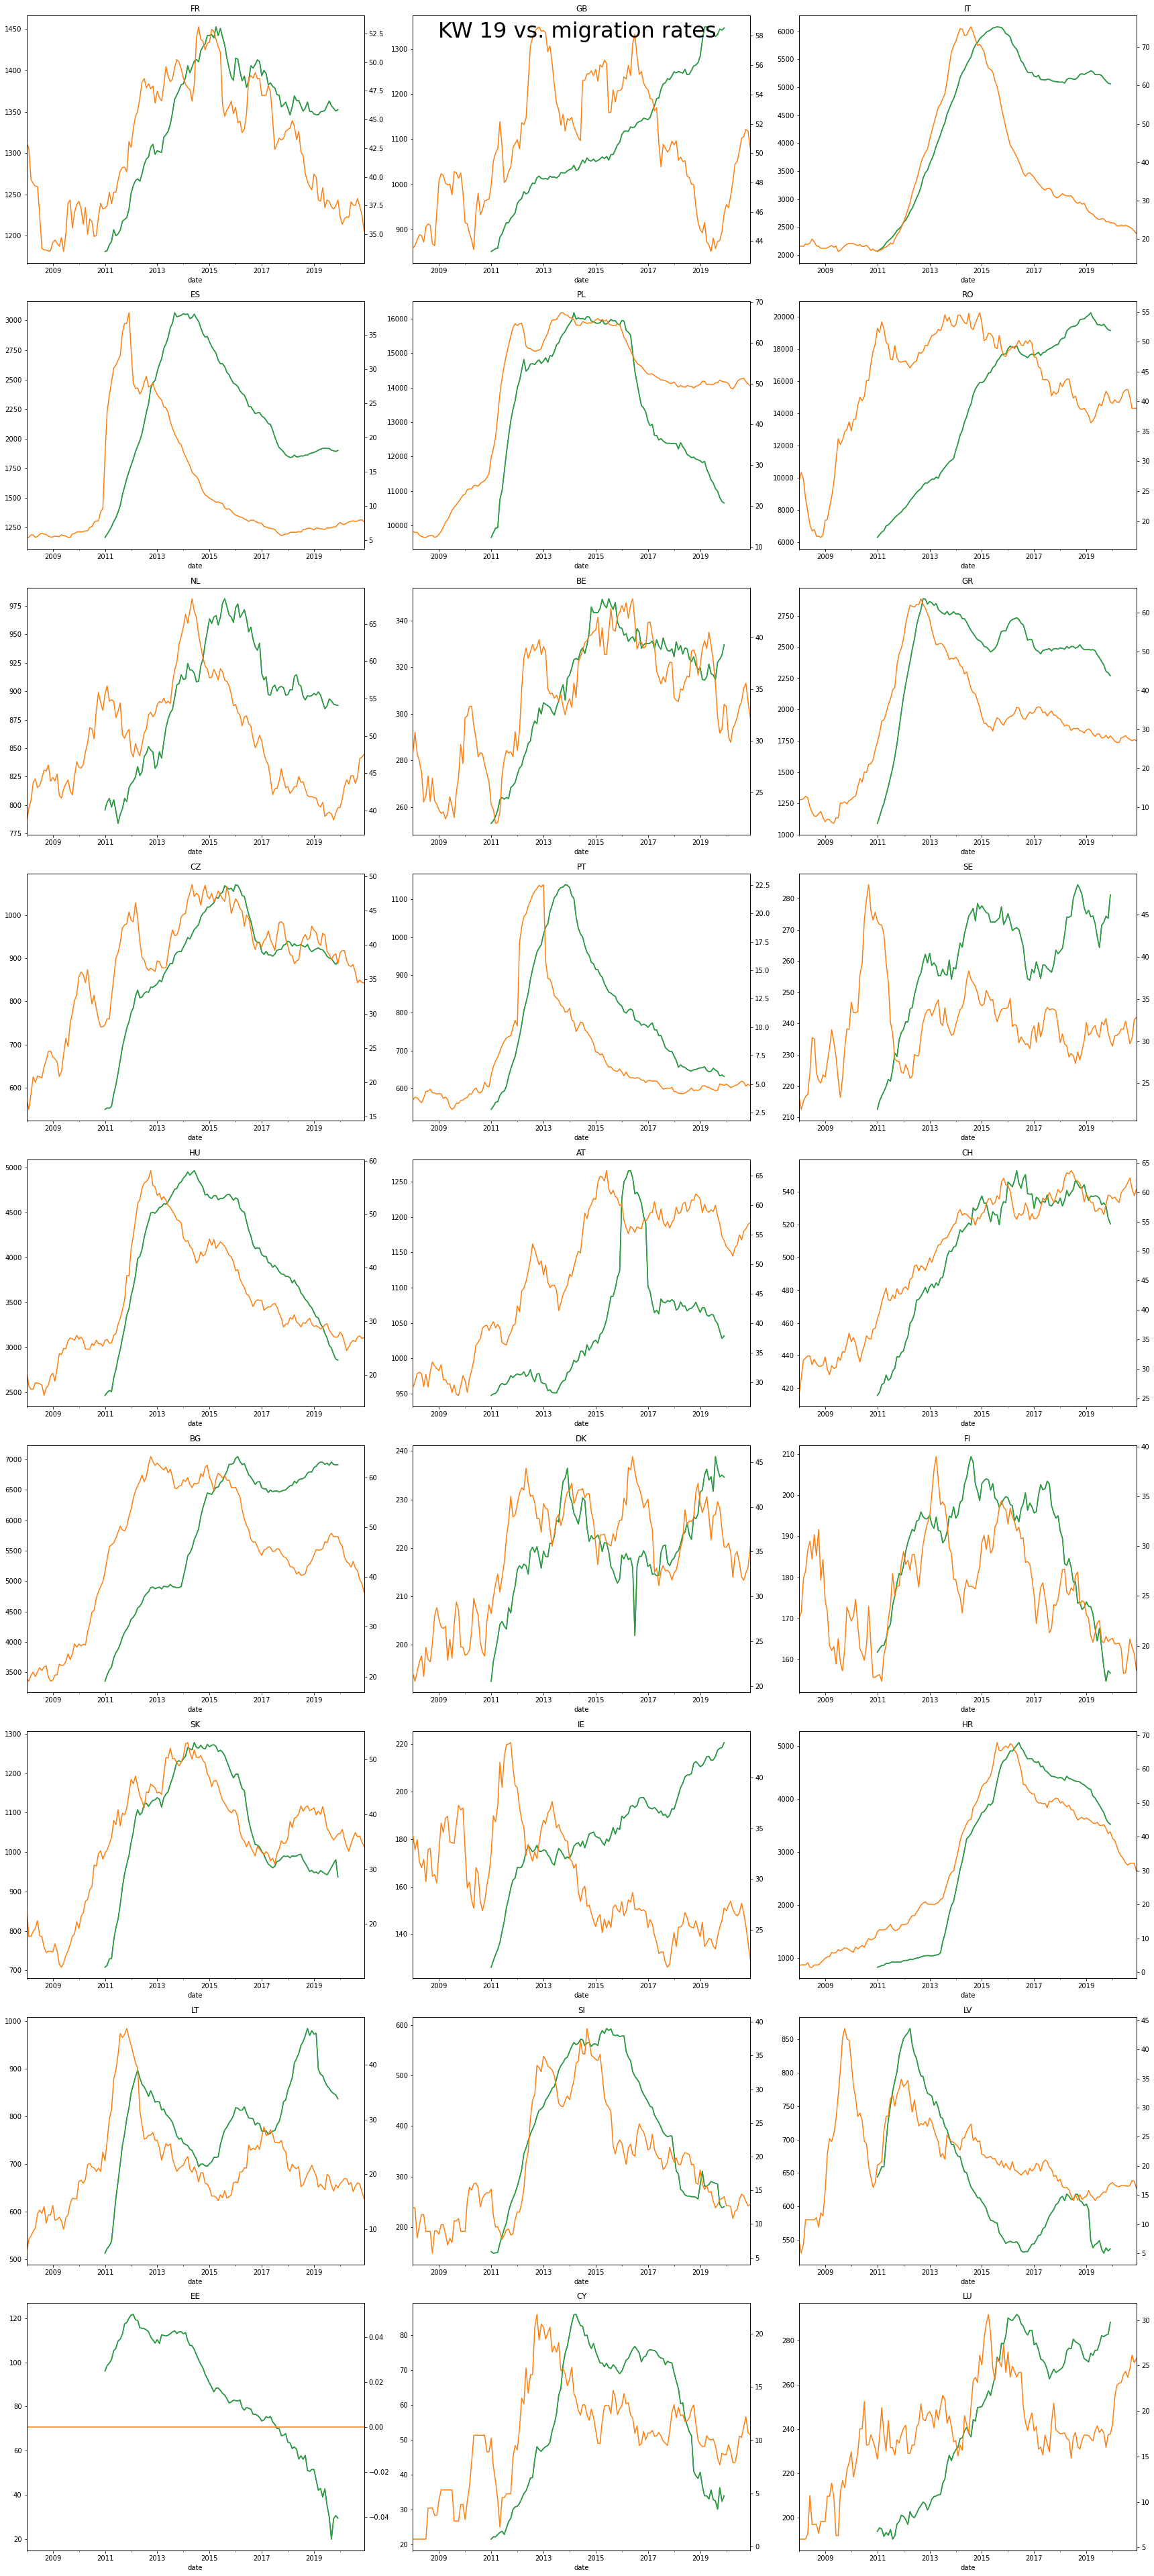

In [13]:
plot_timeseries(
    "19", dfs_rm, series_rm, countries, title="KW 19 vs. migration rates"
)
plt.show()

/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1140: RuntimeWarning: invalid value encountered in true_divide
  return cvf / (np.std(x) * np.std(y))
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


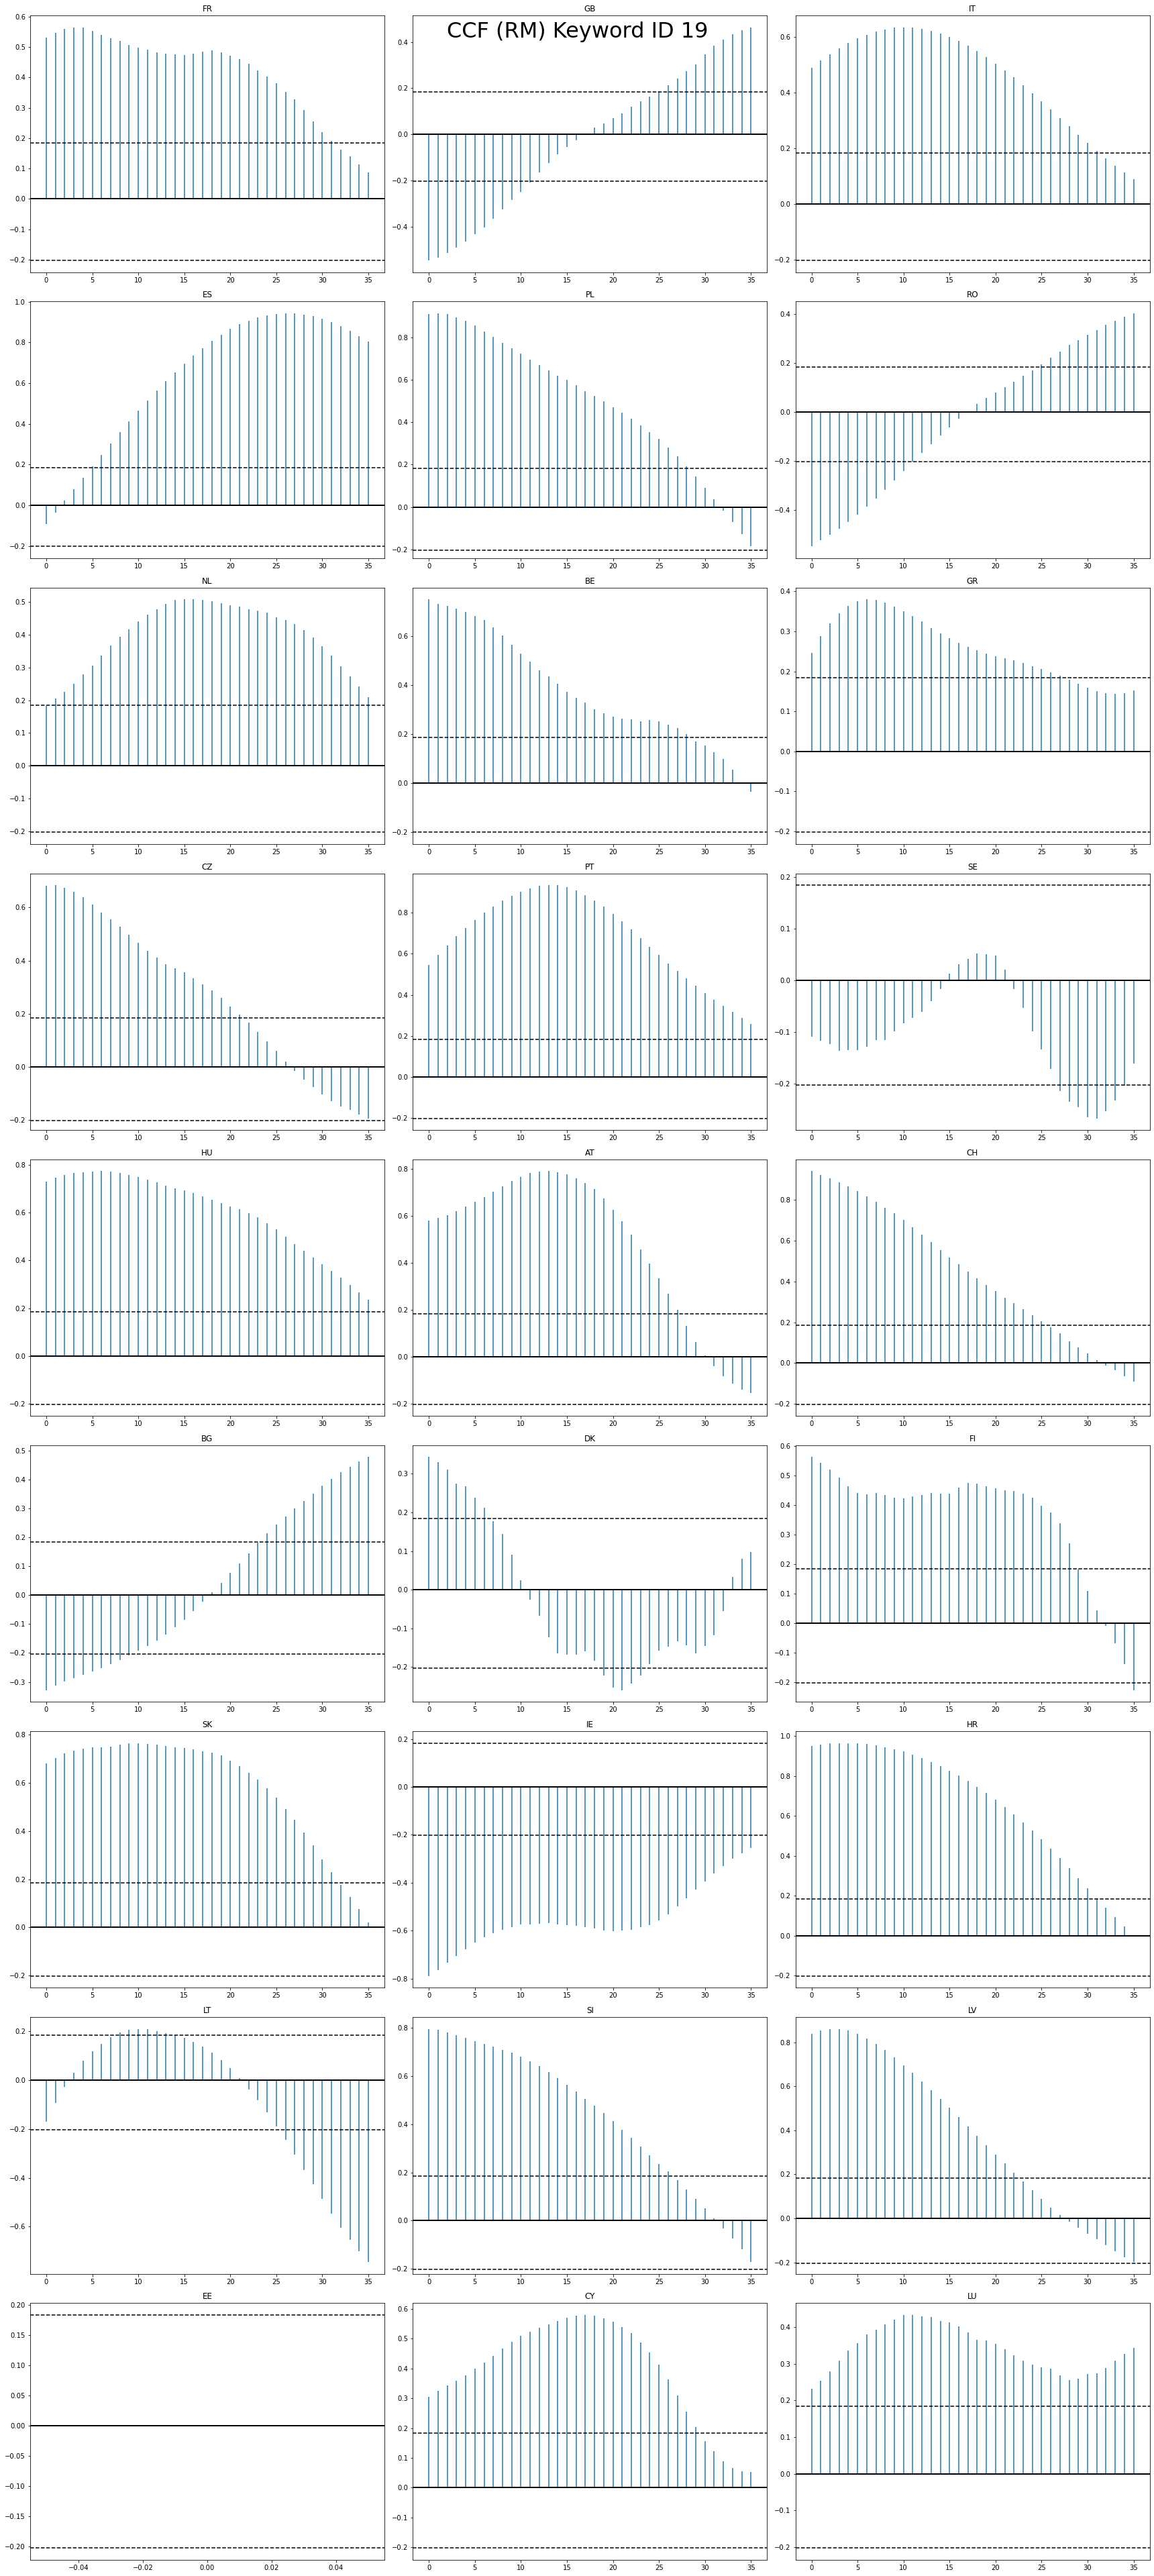

In [14]:
plot_crosscorrelation(
    "19",
    dfs_rm,
    series_rm,
    countries,
    title="CCF (RM)",
    t_min="2011-02"
)
plt.show()


## Seasonal differencing

In [48]:
fcns = {c: dataframes[c].apply(np.sqrt).rolling(12).mean() for c in countries}
dfs_rm = {c: ((dataframes[c].apply(np.sqrt).rolling(6).mean() - dataframes[c].apply(np.sqrt).rolling(6).mean().shift(12))/(dataframes[c].apply(np.sqrt).rolling(6).mean().shift(12) + 1.0))[36:] for c in countries}


In [49]:
# series_resampled = {c: series[c].resample("3M").mean() for c in countries}
series_rm = {c: ((series[c] - series[c].shift(12))/(series[c].shift(12) + 10))[12:] for c in countries}
# series_transformed = {c: (series[c].diff())[1:] for c in countries}
#series_transformed = series


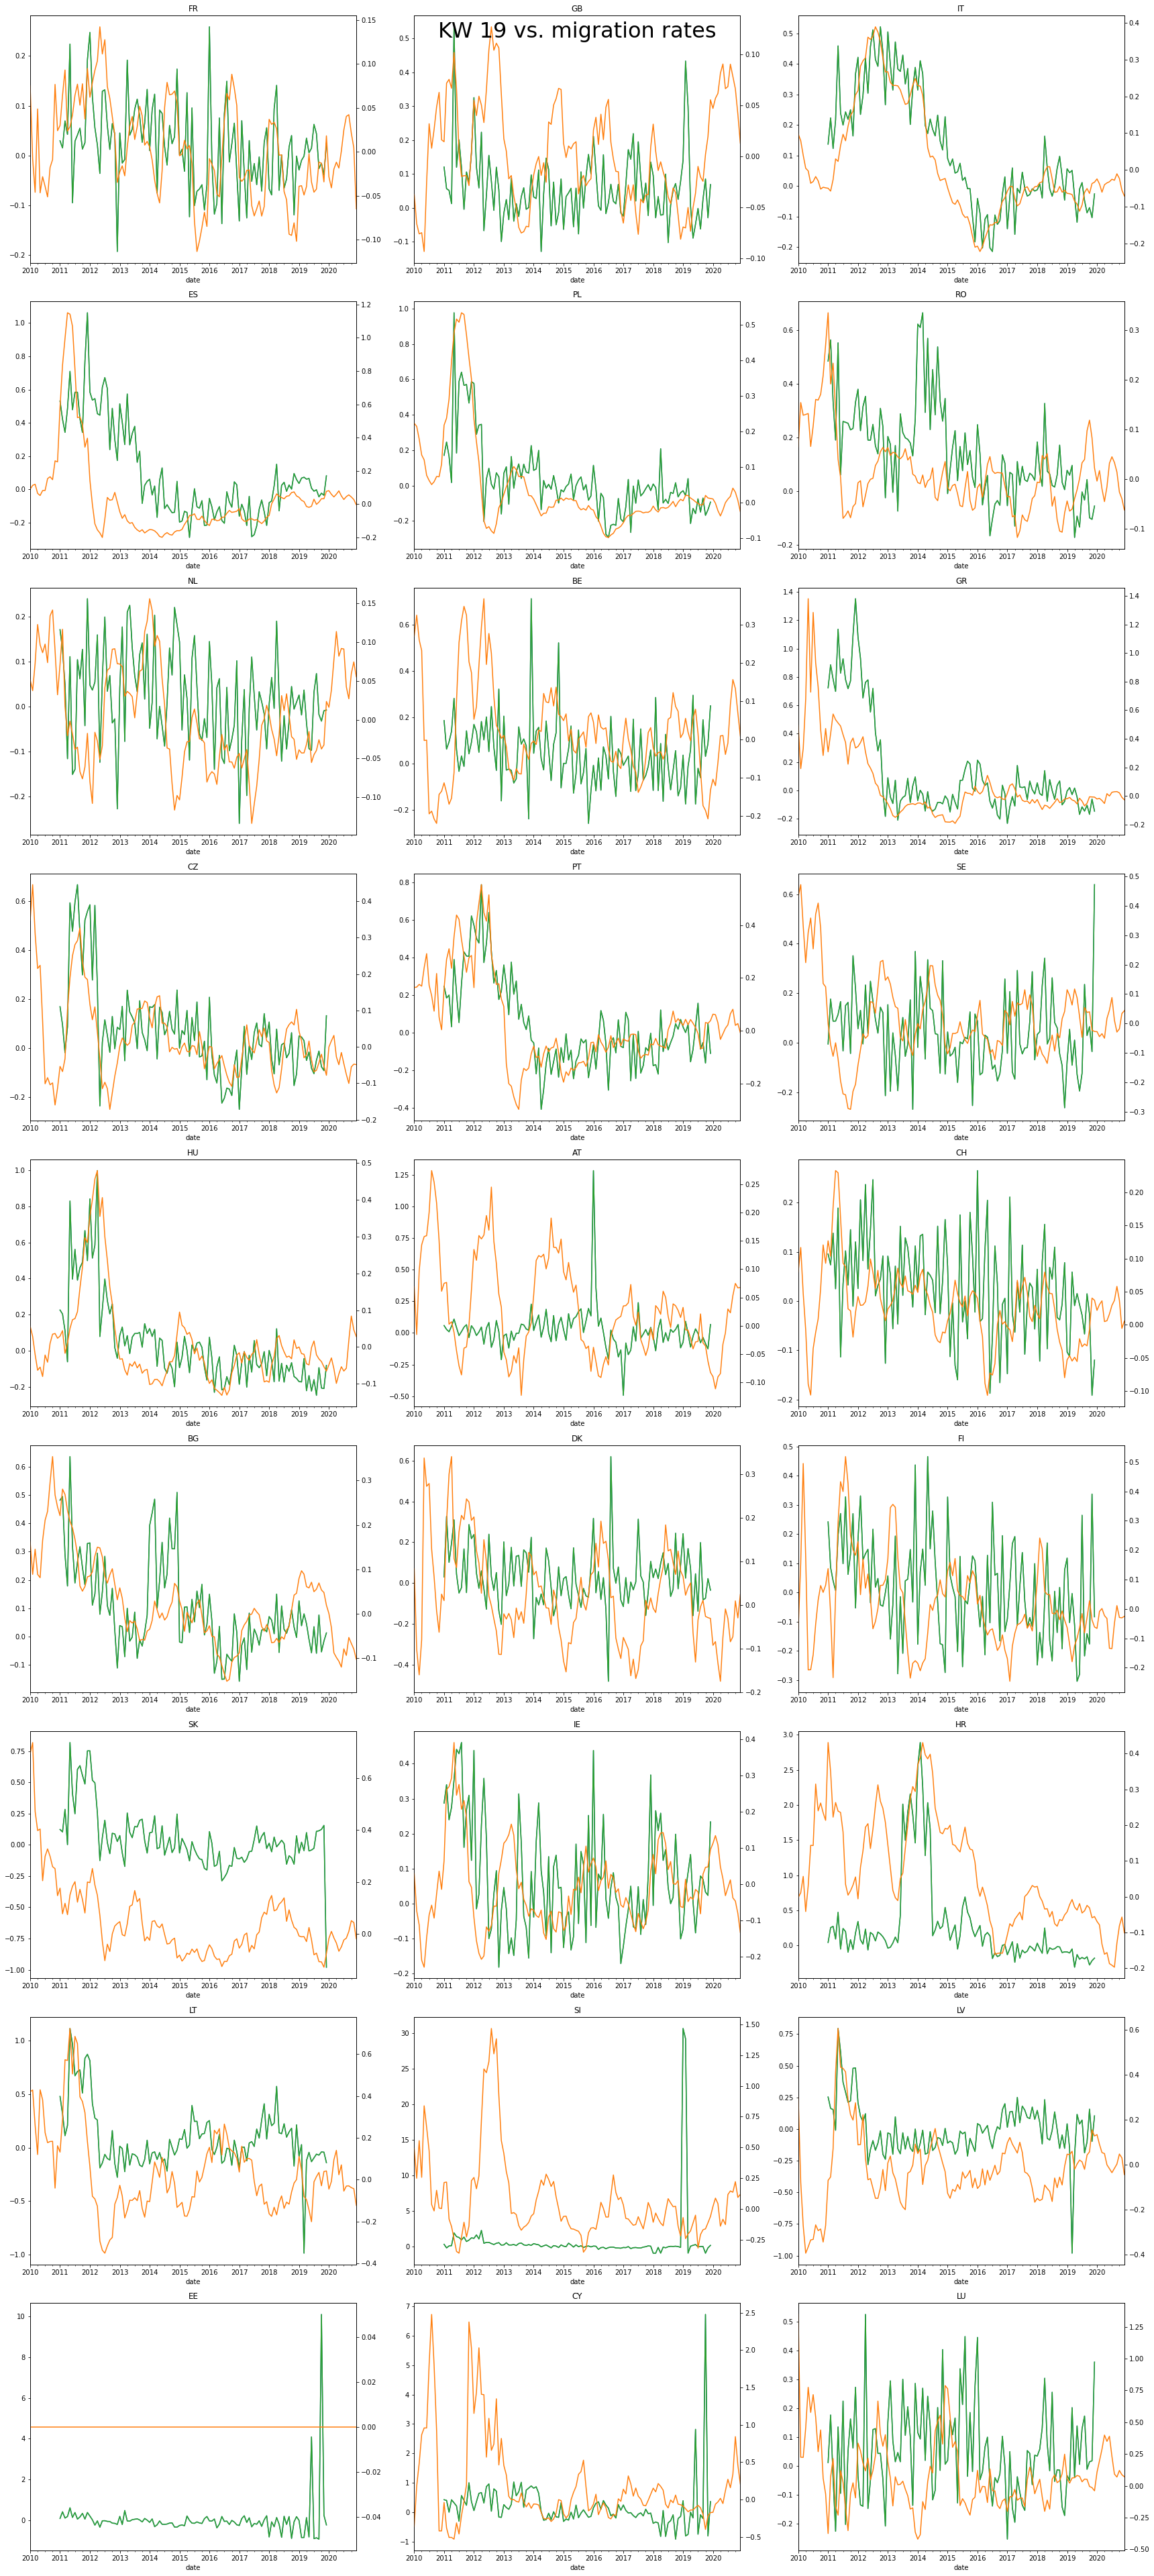

In [50]:
plot_timeseries(
    "19", dfs_rm, series_rm, countries, title="KW 19 vs. migration rates"
)
plt.show()

## Simple differencing

In [ ]:
dfs_transformed_1 = {c: dataframes[c].diff()[1:] for c in countries}
# dfs_transformed = {c: (dataframes[c].diff() - dataframes[c].diff().shift(12))[13:] for c in countries}

In [ ]:
# series_resampled = {c: series[c].resample("3M").mean() for c in countries}
# series_transformed = {c: (series[c].diff() - series[c].diff().shift(12))[13:] for c in countries}
series_transformed_1 = {c: (series[c].diff())[1:] for c in countries}
#series_transformed = series


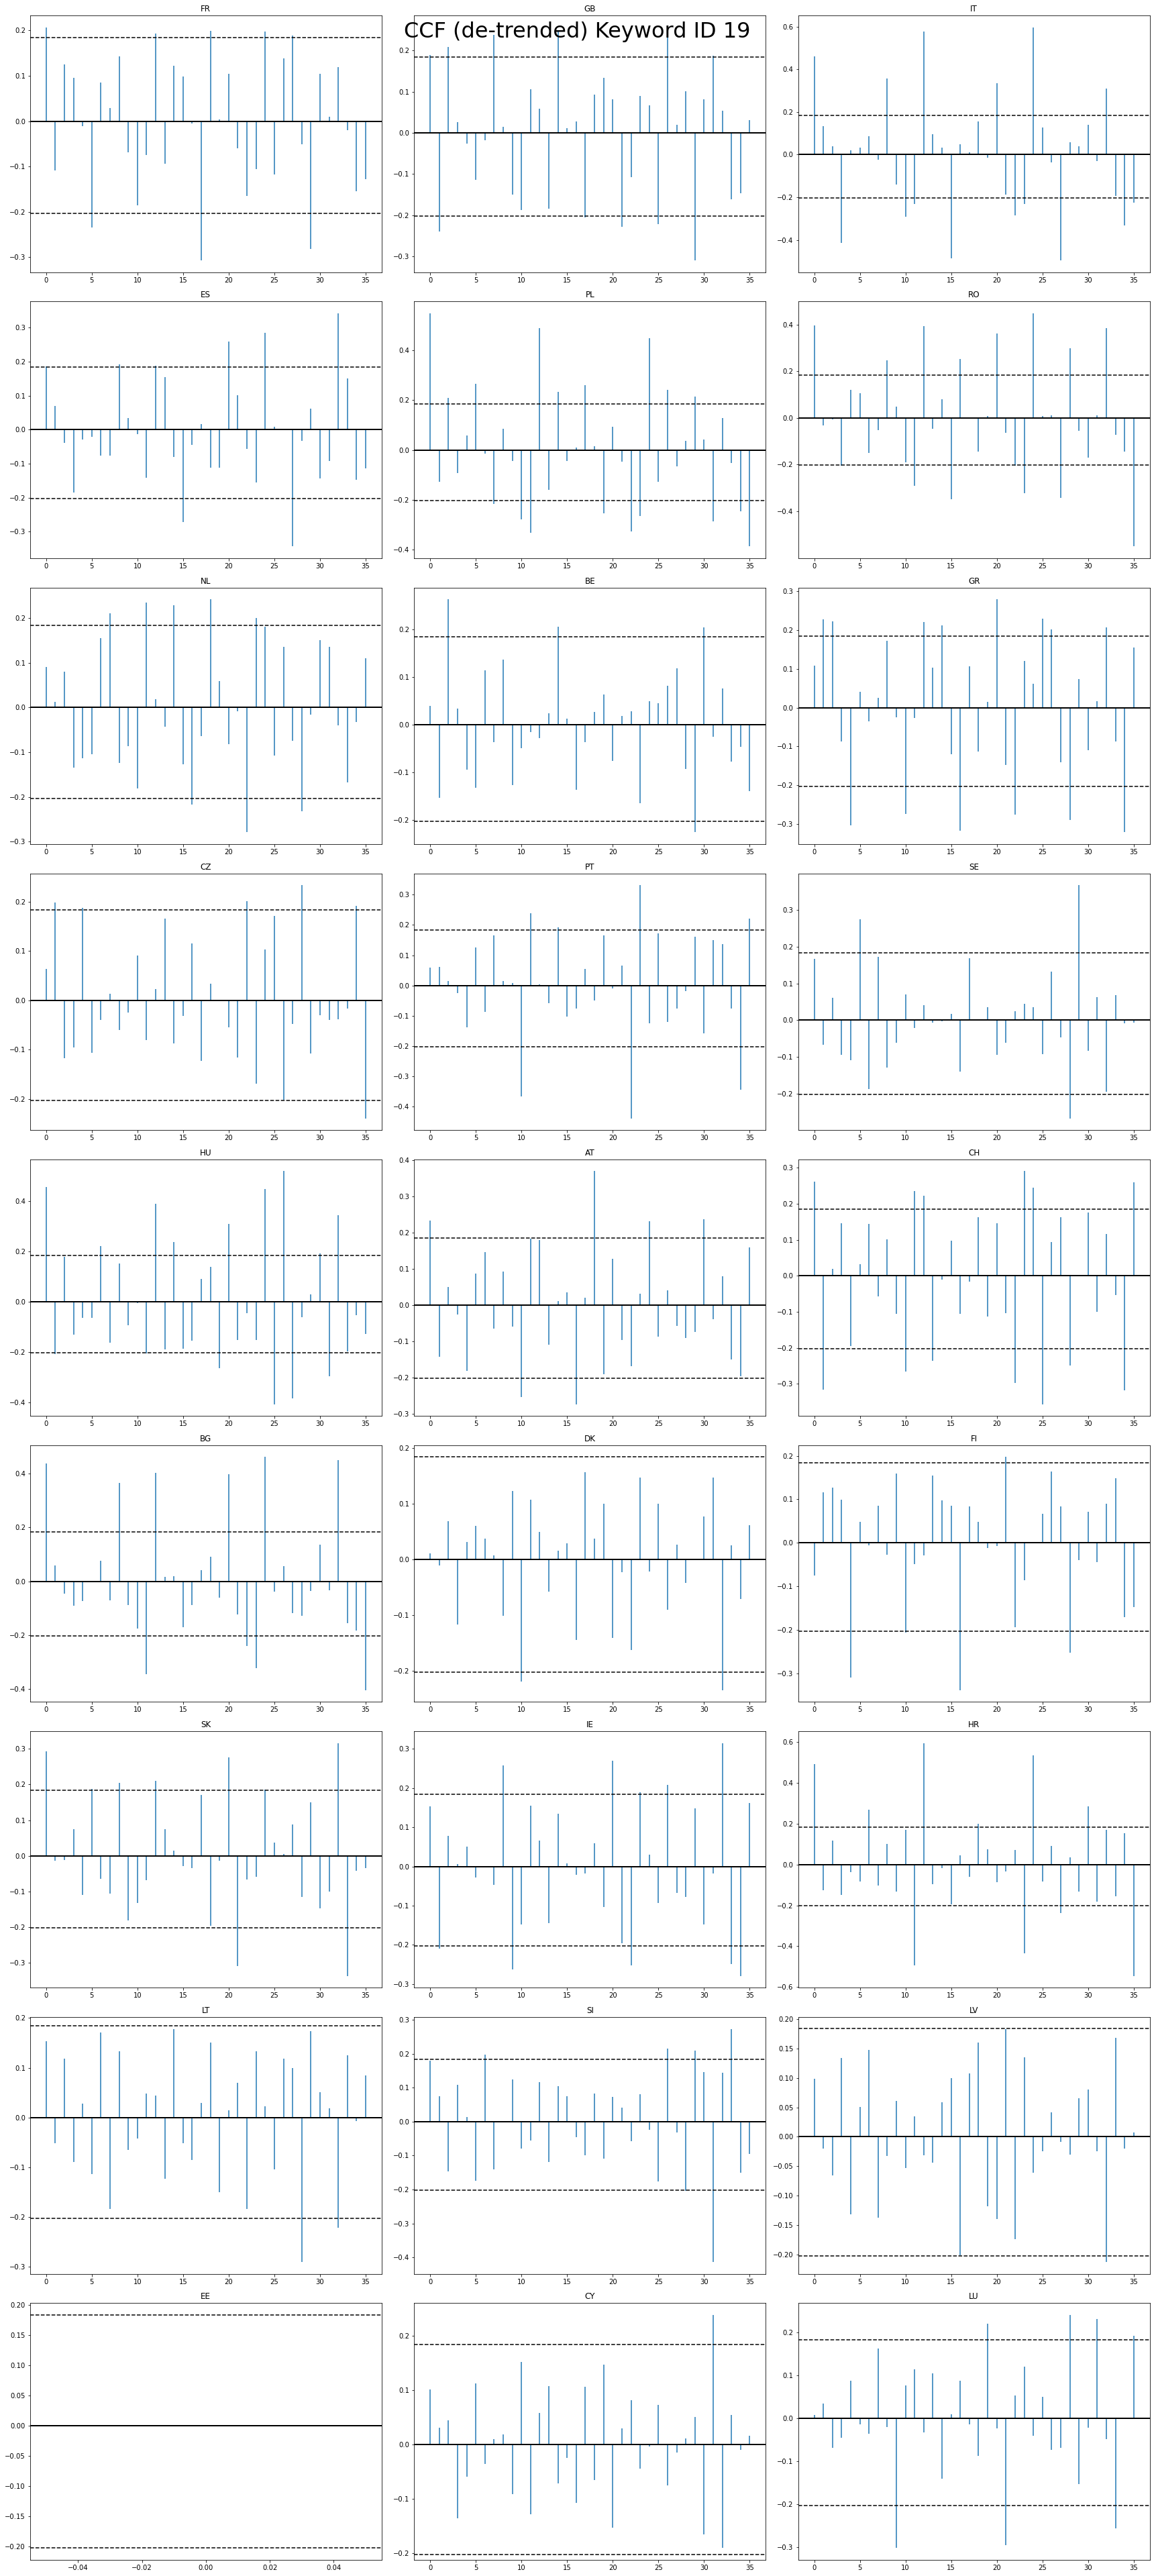

In [ ]:
plot_crosscorrelation(
    "19",
    dfs_transformed_1,
    series_transformed_1,
    countries,
    title="CCF (de-trended)",
    t_min="2011-02"
)
plt.show()


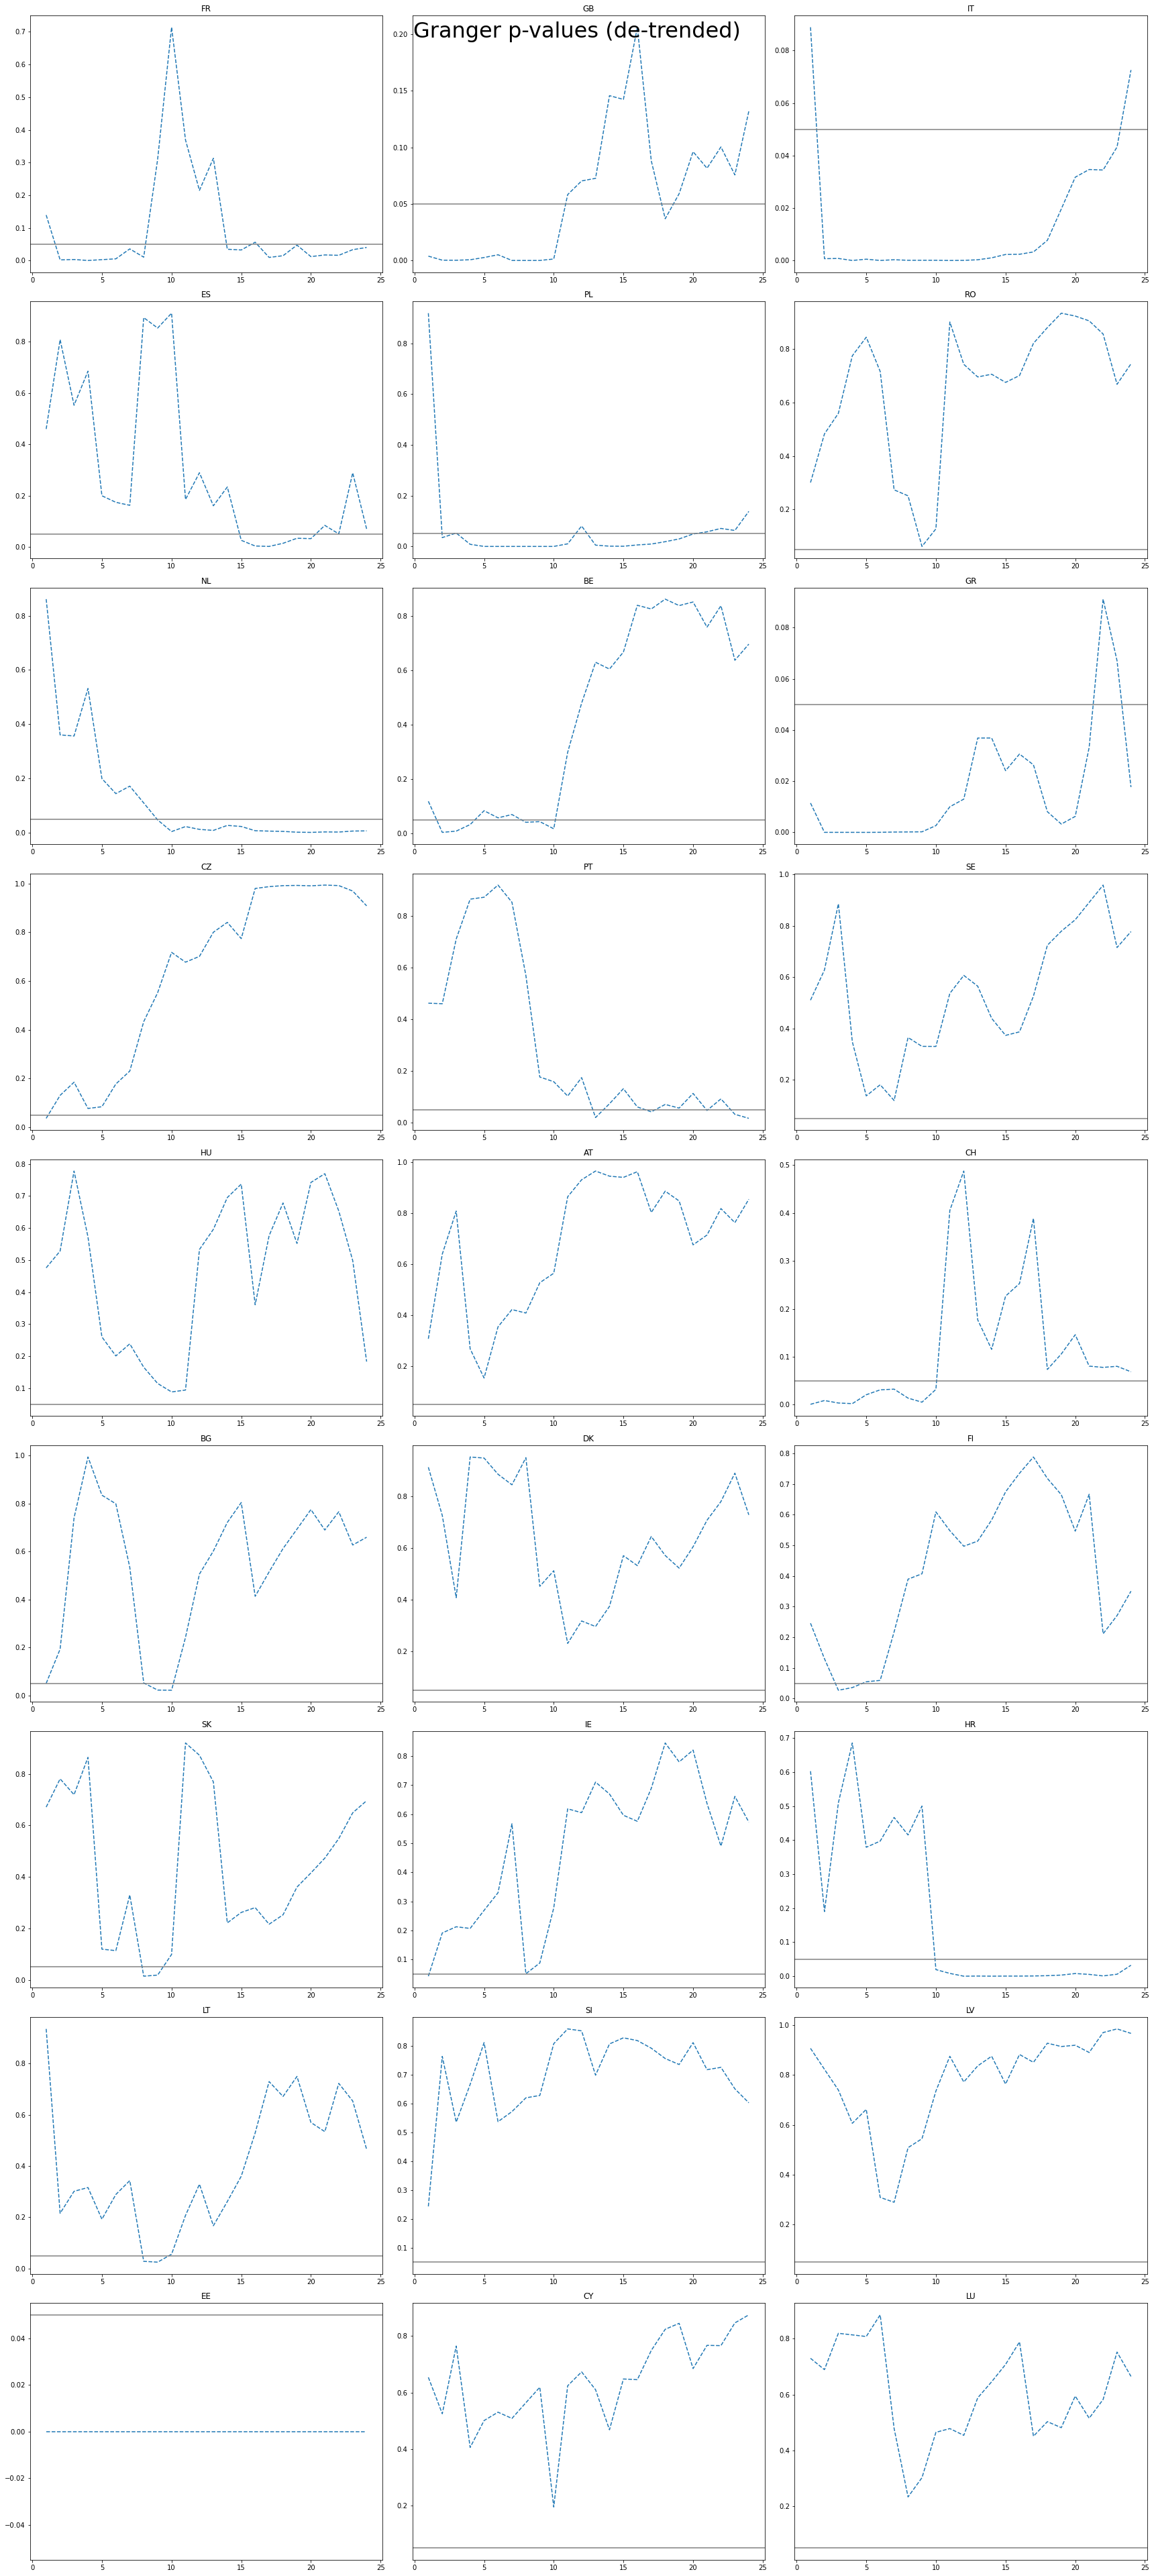

In [ ]:
plot_granger(
    "19",
    dfs_transformed_1,
    series_transformed_1,
    countries,
    title="Granger p-values (de-trended)",
    t_min="2011-02",
    what="p"
)
plt.show()


## Differencing and de-seasonalization

In [ ]:
#dfs_transformed = {c: dataframes[c].diff()[1:] for c in countries}
dfs_transformed_2 = {c: (dataframes[c].diff() - dataframes[c].diff().shift(12))[13:] for c in countries}

In [ ]:
# series_resampled = {c: series[c].resample("3M").mean() for c in countries}
series_transformed_2 = {c: (series[c].diff() - series[c].diff().shift(12))[13:] for c in countries}
#series_transformed = {c: (series[c].diff())[1:] for c in countries}
#series_transformed = series


/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1140: RuntimeWarning: invalid value encountered in true_divide
  return cvf / (np.std(x) * np.std(y))
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


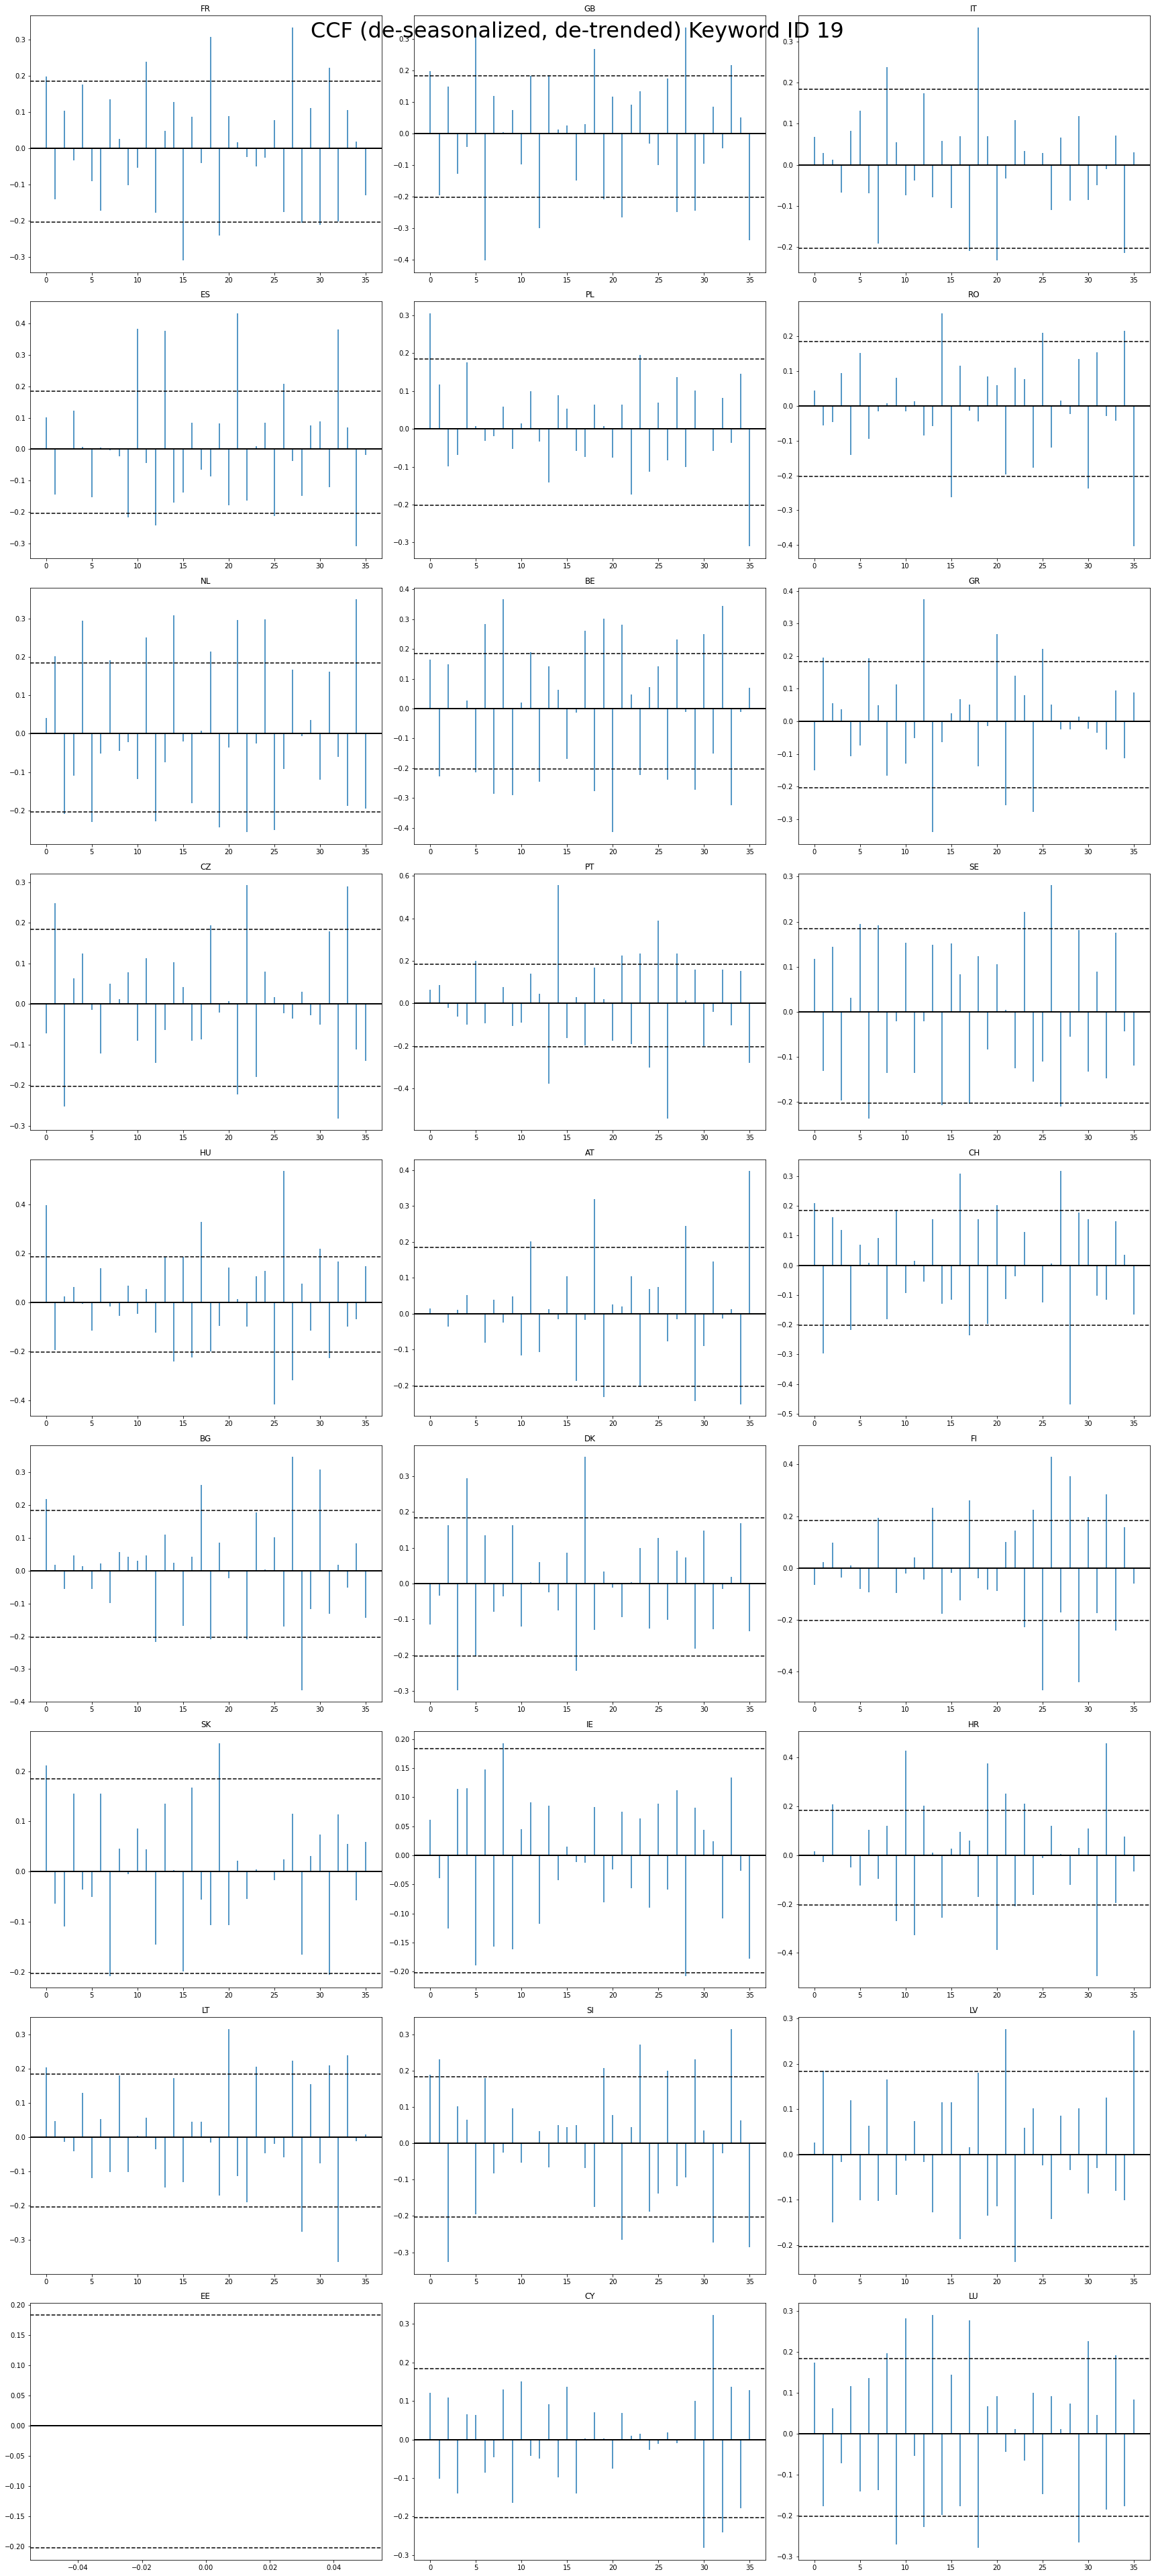

In [ ]:
plot_crosscorrelation(
    "19",
    dfs_transformed_2,
    series_transformed_2,
    countries,
    title="CCF (de-seasonalized, de-trended)",
    t_min="2011-02"
)
plt.show()


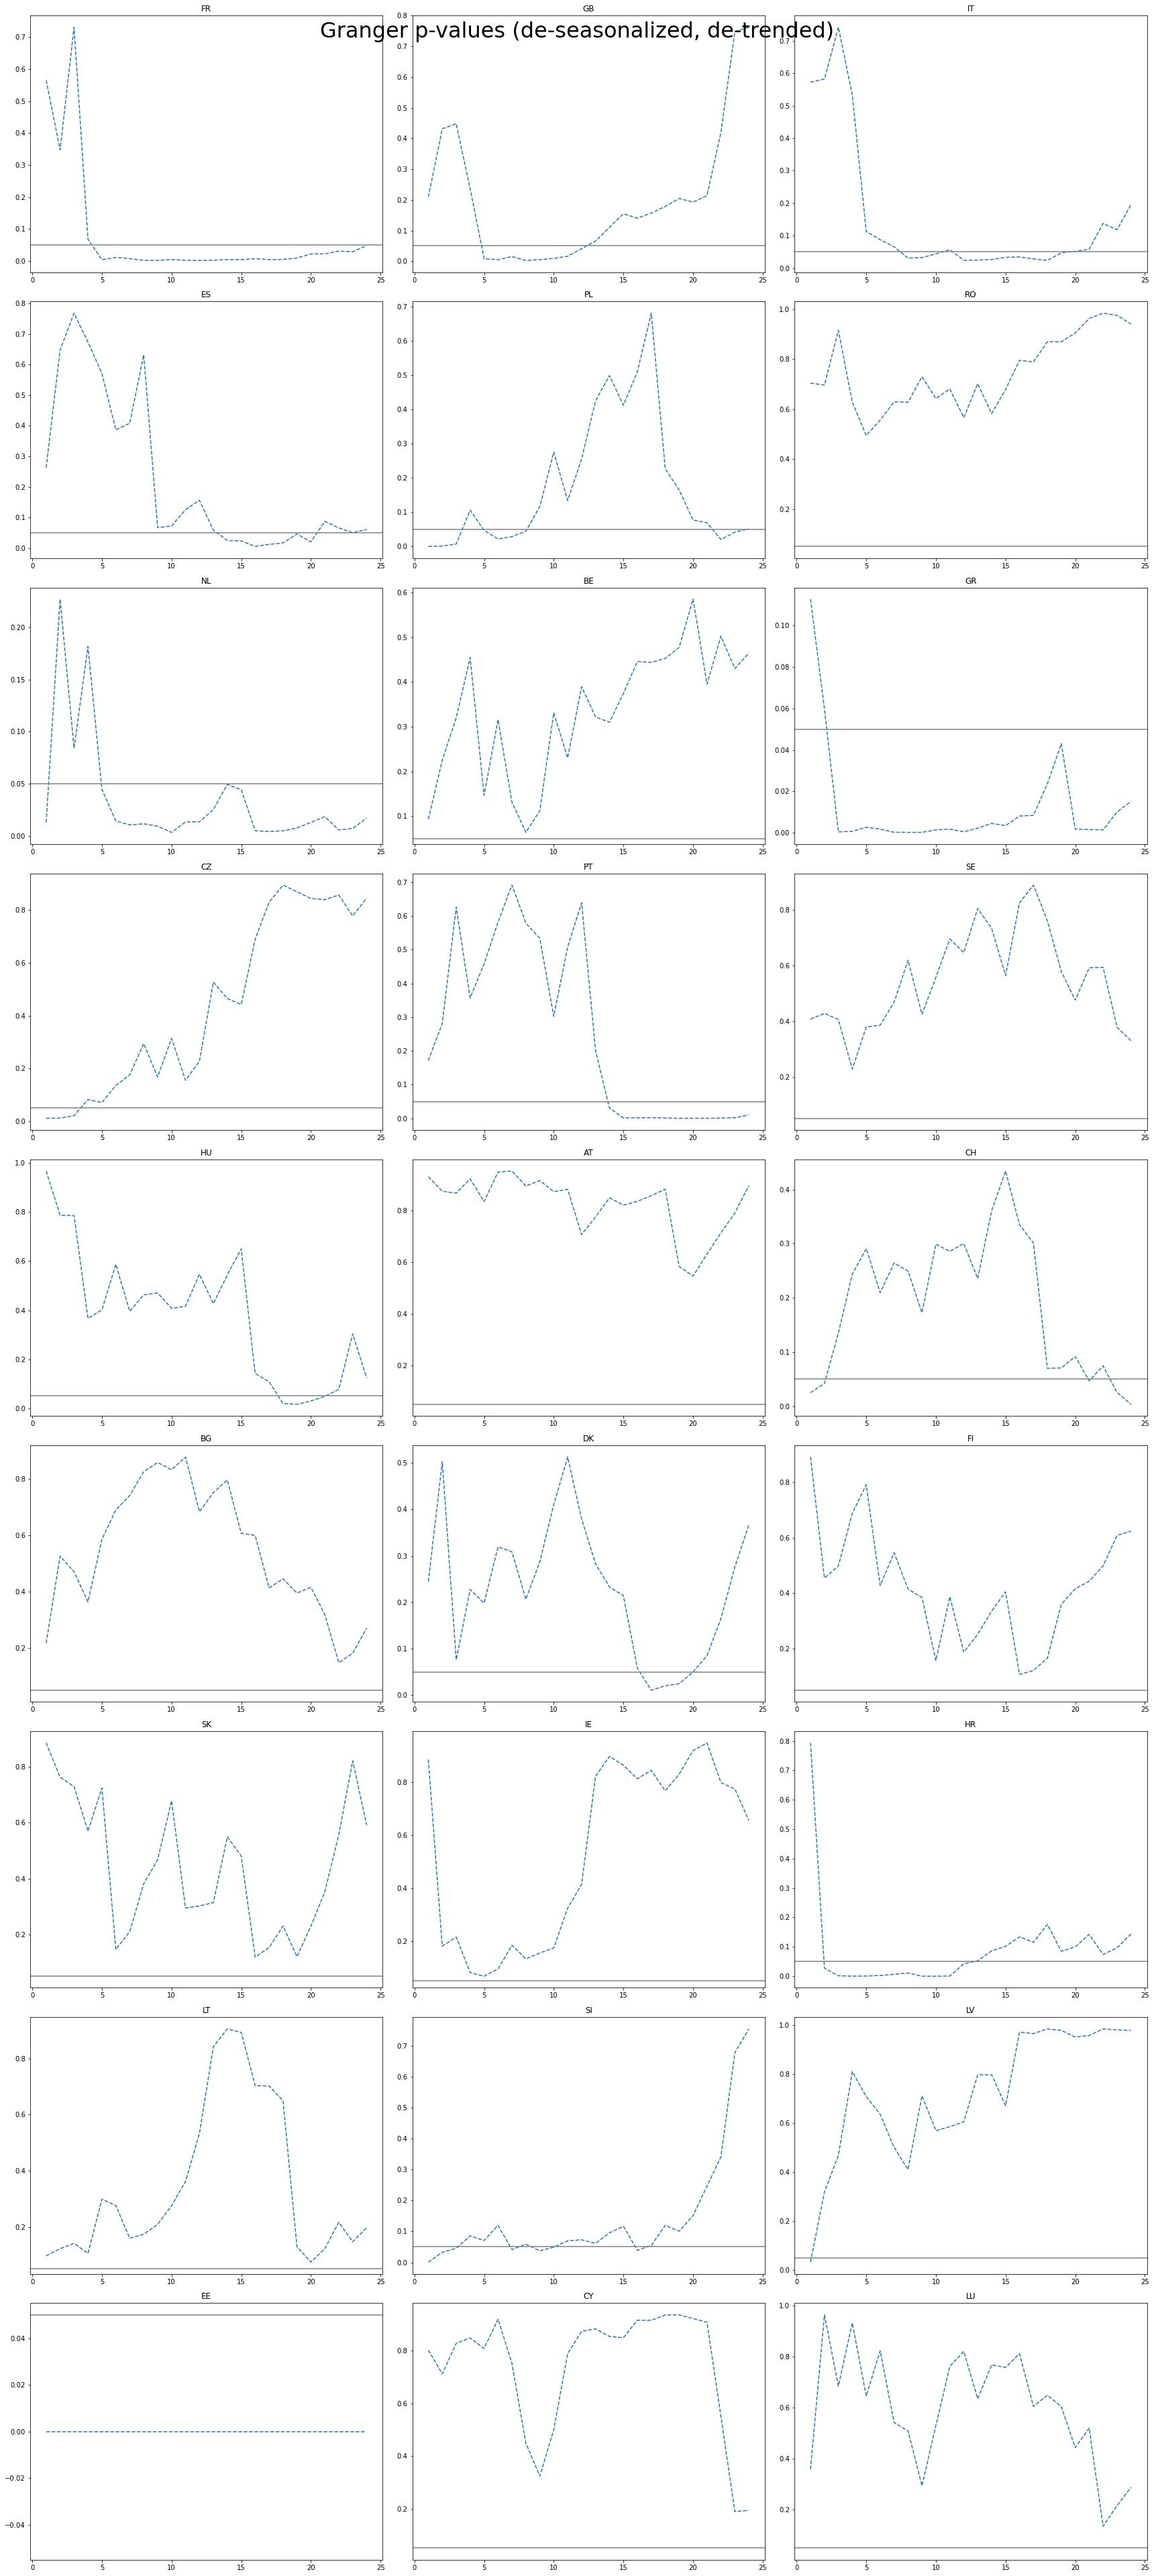

In [ ]:
plot_granger(
    "19",
    dfs_transformed_2,
    series_transformed_2,
    countries,
    title="Granger p-values (de-seasonalized, de-trended)",
    t_min="2011-02",
    what="p"
)
plt.show()


Min Granger p-value and Lag

In [ ]:
keywords = dfs_transformed_2["FR"]["mean"].columns.to_list()[0:3]
dfs_granger = []

for k in keywords:

    p_vals, lags = get_best_granger_values(
        k, dataframes, series, countries,
    )

    dfs_granger.append(pd.DataFrame([p_vals], columns=countries, index=[k]))

df_ganger = pd.concat(dfs_granger)
df_ganger


['2', '10', '11', '12', '14', '15', '16', '17', '18', '19', '20', '21', '22', '24', '26', '28', '32', '33', '37', '38', '39', '41', '42', '43', '44', '48', '49', '51', '52', '54', '55', '56', '57', '58', '59', '60', '112', '113', '114', '115', '117', '118', '119', '121', '122', '123', '124', '125']


GB
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 19, BIC -> 1, FPE -> 12, HQIC -> 12>
Using 19 based on aic criterion
FR
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 20, BIC -> 2, FPE -> 12, HQIC -> 12>
Using 20 based on aic criterion
IT
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 20, BIC -> 1, FPE -> 15, HQIC -> 20>
Using 20 based on aic criterion
ES
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 20, BIC -> 2, FPE -> 19, HQIC -> 19>
Using 20 based on aic criterion
PT
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 20, BIC -> 1, FPE -> 16, HQIC -> 20>
Using 20 based on aic criterion
PL
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 20, BIC -> 1, FPE -> 12, HQIC -> 6>
Using 20 based on aic criterion
NL
<statsmodels.tsa.vector_ar.var_m

LinAlgError: 3-th leading minor of the array is not positive definite

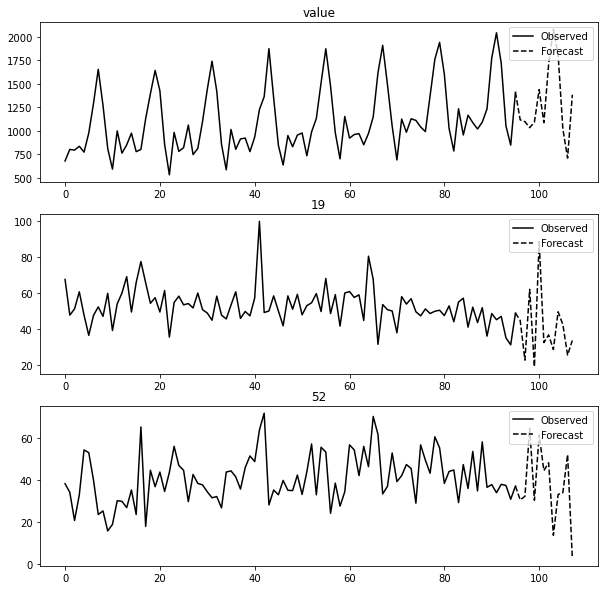

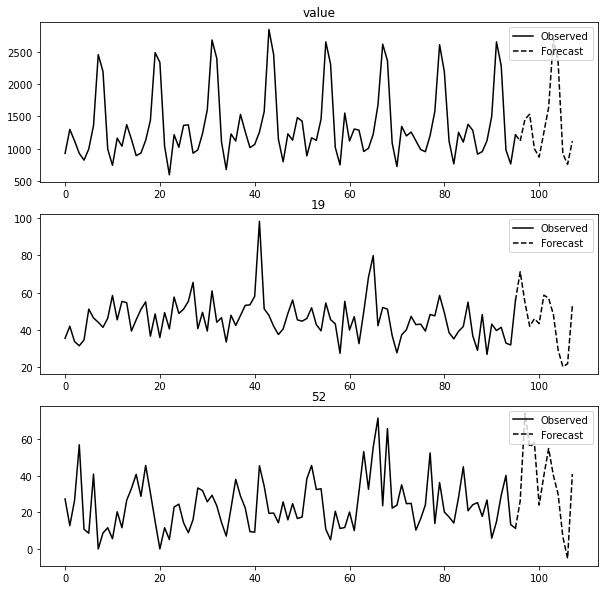

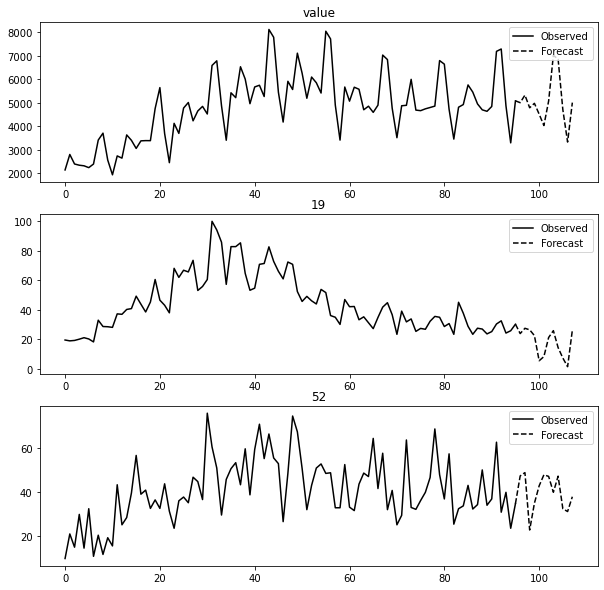

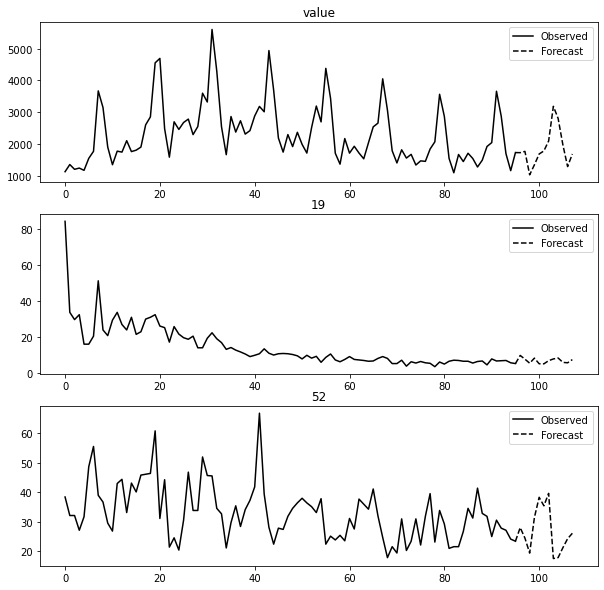

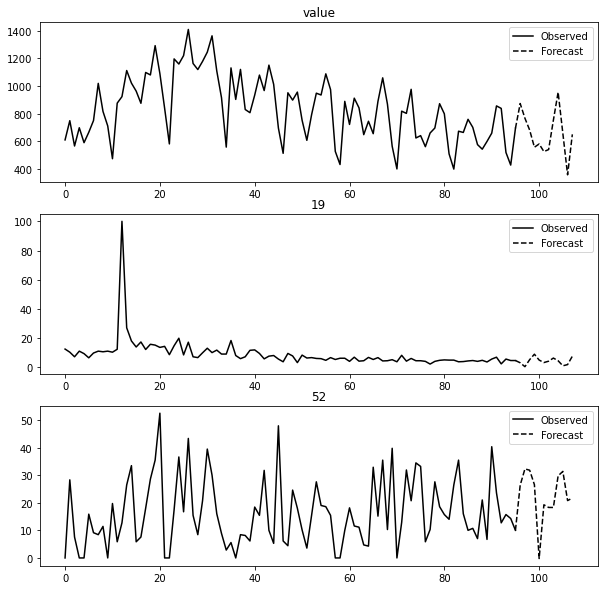

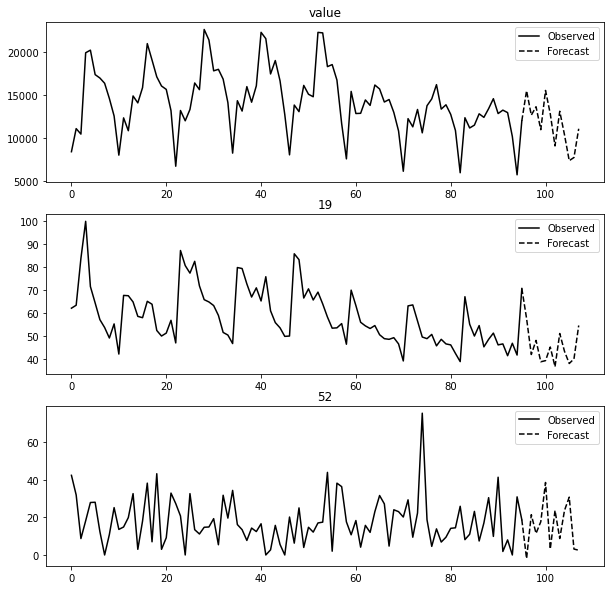

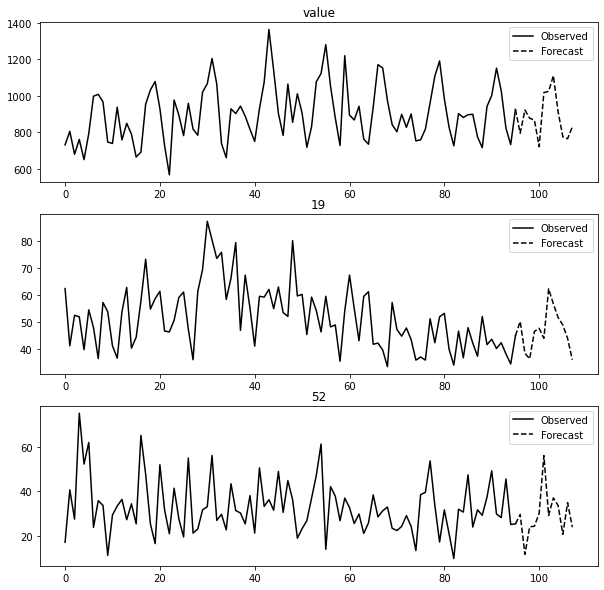

In [ ]:
for c in ["GB", "FR", "IT", "ES", "PT", "PL", "NL", "HR"]:
    data = pd.concat([series[c], dataframes[c]["mean"]], axis=1)[["value", "19", "52"]]
    var = sm.tsa.VAR(data["2011-01-02":"2019-01-01"])
    print(c)
    results = var.fit(20, ic="aic", verbose=True)
    results.forecast(data["2011-01-02":"2019-01-01"].values, steps=2)
    results.plot_forecast(12, plot_stderr=False)
    #results.plot()

In [ ]:
pd.concat([series_transformed_2["NL"], dfs_transformed_2["NL"]["mean", "19"]], axis=1)["2011-01-01":"2019-01-01"]

In [ ]:
dataframes["NL"]["mean", "19"]